# Water management

We will control a dam responsible for dispatching water downstream, as well as avoid flooding in the region. This environment is modelled as a one-dimensional, continuous state, representing the amount of water present in the reservoir. This is subject to change, depending on factors such as rain.

At each timestep, the dam can release a specified water amount (a one-dimensional, continuous action).

The dam is responsible with supplying water, and needs to meet the water demand. At the same time, it should be careful not to hold too much water, as this increases the risk of flooding upstream.

These objectives are conflicting, since the inflow of water is on average insufficient to cope with the water demand. In order to increase the change of meeting future demand, the reservoir needs to be filled, thus increasing the risk of flooding upstream.

## Multi-objective Natural Evolution Strategies ##

With an unknown utility function, that can be non-linear, we want to propose a set of alternatives to the decision makers, by approximating the Pareto-front. Since we have no prior information about the preferences of the decision makers, we make no assumptions about the utility function.

The algorithm that will be used to approximate the coverage set is Multi-objective Natural Evolution Strategies (MONES). In essence, a parametric policy is used, where each parameter is represented by a Gaussian distribution. Sampling these distributions will result in an executable policy that can be applied on our environment. MONES will optimize the mean and standard-deviation of each parameter such that, each time we sample from them, we will have a policy that leads to a different point on the Pareto front.

MONES is an iterative process, that repeats 3 steps:

1. sample a population of policies from our parameters, and execute them on the environment
2. evaluate the quality of these policies using an indicator metric
3. perform a gradient step that improves this indicator, using the natural gradient

Our policy will be a small feedforward neural network, where each weight will be sampled from its own Gaussian distribution.

As an indicator metric, we will use non-dominance ranking combined with crowding distance. For non-dominance ranking:

- The non-dominated points of the discovered returns will have a rank of 0.
- After removing these points, the new non-dominated points will have a rank of -1.
- This process is repeated until no points remain.

The crowding distance is a metric providing information about the diversity of a frontier:

- for all the points of the same rank we compute, for each dimension, the distance between its closest neighbours.
- this distance is normalized. Points close to each other will have a crowding distance close to 0, while points at the border of the frontier will have a distance close to 1.

Summing these 2 metrics together provides us with an indicator that encourages points to be on the Pareto front, and be as diverse as possible.

### Gym Environment

Our environment follows the Gym API (and is a subclass of `gym.Env`), with 2 small changes for multi-objective optimization:

1. The reward returned at every timestep is a numpy array, instead of a scalar
2. The `reward_range` property is changed to `reward_space`, providing bounds for each separate objective.

2 functions are of interest:

1. `reset() → s:np.ndarray` restarts the environment and provides the start-state `s`
2. `step(action:float) → (s:np.ndarray, rew:np.ndarray, done:bool, info:dict)` performs action `action` and returns a tuple with the next-state `s`, corresponding reward `rew`, a flag stating if the state is terminal `done`, and additional information `info`

We limit the episode to 100 timesteps, using the `gym.wrappers.TimeLimit` wrapper.

In [1]:
import gym
from gym.wrappers import TimeLimit
import envs.dam
import numpy as np

max_episode_steps = 100

def make_env():
    env = gym.make('Dam-v0')
    env = TimeLimit(env, max_episode_steps)
    return env

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Actor(nn.Module):
    def __init__(self, nS, nA, hidden=50):
        super(Actor, self).__init__()

        self.nA = nA
        self.fc1 = nn.Linear(nS, hidden)
        self.fc2 = nn.Linear(hidden, nA)

        nn.init.xavier_uniform_(self.fc1.weight, gain=1)
        nn.init.xavier_uniform_(self.fc2.weight, gain=1)

    def forward(self, state):

        # actor
        a = self.fc1(state)
        a = torch.tanh(a)
        a = self.fc2(a)
        return a

### Creating the learner

Our MONES learner will train for 30 iterations, sampling 50 policies every time. Each policy will be executed 10 times. The average return of each policy will be evaluated using the non-dominance/crowding-distance metric.

In [3]:
from learners.mones import MONES
from datetime import datetime
import uuid

logdir = 'runs/'
logdir += datetime.now().strftime('%Y-%m-%d_%H-%M-%S_') + str(uuid.uuid4())[:4] + '/'

agent = MONES(
    make_env,
    Actor(1, 1, hidden=50),
    n_population=50,
    n_runs=10,
    logdir=logdir
)

In [4]:
# agent.train(30)
# torch.save({' dist': agent.dist, ' policy': agent.policy}, logdir + 'checkpoint.pt')

### Plotting the training over time

We will plot the evulation of the population returns for each iteration. On the left-side, we will show all points discovered, and on the right the non-dominated subset of these points.

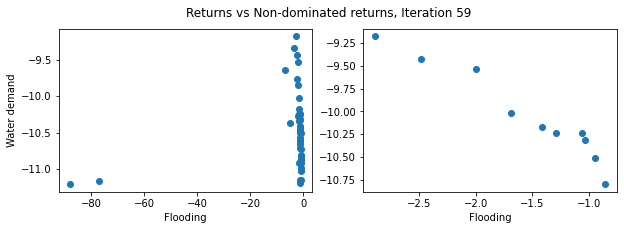

In [5]:
import time
import h5py
import pylab as plt
from IPython import display
from metrics import non_dominated, compute_hypervolume

# logdir = 'runs/2020-09-30_17-25-55_b0fe/'
logdir = 'runs/2020-10-12_15-18-19_e1c3/'
logfile = h5py.File(logdir + 'log.h5', 'r')
returns = logfile['train/returns/ndarray'].value
returns /= 100

for i in range(returns.shape[0]):
    current_returns = returns[i]
    current_nd = non_dominated(current_returns)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
    ax1.scatter(current_returns[:,0], current_returns[:,1])
    ax2.scatter(current_nd[:,0], current_nd[:,1])
    fig.suptitle(f'Returns vs Non-dominated returns, Iteration {i}')
    ax1.set_xlabel('Flooding')
    ax2.set_xlabel('Flooding')
    ax1.set_ylabel('Water demand')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(.1)
    if i < returns.shape[0]-1:
        plt.close()
display.clear_output(wait=False)

### Hypervolume

Although the hypervolume metric was never used during training, we can compute it, to give us an impression of the evolution of the coverage set over time.

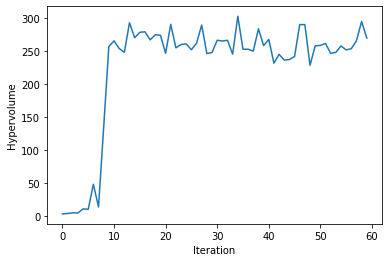

In [6]:
ref_point = np.min(returns.reshape(-1, 2), axis=0)
hypervolumes = [compute_hypervolume(ret, ref_point) for ret in returns]

plt.figure()
plt.plot(hypervolumes)
plt.xlabel('Iteration')
plt.ylabel('Hypervolume')
plt.show()


## Using Linear Weights and Single-objective subroutines

TODO

## Using Natural Evolution Strategies (NES) to optimize reward.

Instead of using a dedicated method (MONES) to discover diverse policies, we will use an outer loop method. In this particular case, we will use Natural Evolution Strategies (NES) as a single objective subroutine. This subroutine will be called a number of times, each time with different weights, hopefully resulting in different policies, that reach different points of the Coverage set.

NES will be called 30 times on our 2-objective problem with, for each iteration, a slight increase in weight `w_0`.

In [7]:
from wrappers.linear_scalarization import LinearScalarization


class VectorizeReward(gym.RewardWrapper):
    def reward(self, rew):
        return np.array([rew])


def make_ls_env(weights):
    weights = weights
    env = make_env()
    env = LinearScalarization(env, weights)
    env = VectorizeReward(env)
    return env


def make_so_subroutine(w):
    agent = MONES(
        lambda w=w: make_ls_env(w),
        Actor(1, 1, hidden=50),
        n_population=50,
        n_runs=10,
        indicator='single_objective',
        logdir=logdir + f'w_{w[0]}/'
    )
    return agent

In [8]:
# for w_0 in np.linspace(0, 1, 30):
#     print('='*10 + str(w_0) + '='*10)
#     agent = make_so_subroutine(np.array([w_0, 1.-w_0]))
#     agent.train(50)
#     torch.save({'dist': agent.dist, 'policy': agent.policy}, agent.logdir + 'checkpoint.pt')
#     display.clear_output(wait=False)

## Plotting the results

After 30 calls of our NES subroutine, we end up with 30 different policies. We evaluate each policy and plot the corresponding return.

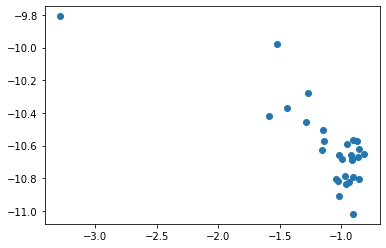

In [9]:
from pathlib import Path

tmp_agent = MONES(
    make_env,
    Actor(1, 1, hidden=50),
    n_population=1,
    n_runs=30,
    logdir=None
)

w_returns = []

plt.figure()
for wpath in Path(logdir).rglob('w_*/checkpoint.pt'):
    state_dict = torch.load(wpath)
    tmp_agent.dist = state_dict['dist']
    tmp_agent.policy = state_dict['policy']
    pop, _ = tmp_agent.sample_population()
    r = tmp_agent.evaluate_population(make_env(), pop)
    r = np.mean(r.reshape(-1, 2).detach().numpy(), axis=0, keepdims=True)
    r /= 100
    w_returns.append(r)
w_returns = np.concatenate(w_returns, axis=0)
valid_w = w_returns[:, 0] > -5
w_returns = w_returns[valid_w]
plt.scatter(w_returns[:,0], w_returns[:,1])
plt.show()

## Comparing with MONES

Next, we will compare the policies found using MONES with those found by the outer loop method.

The first plot shows the different returns found using the MONES policies.

In the second plot, we show a side-by-side comparison of MONES policies (in orange) and NES policies with linear scalarization (in blue).

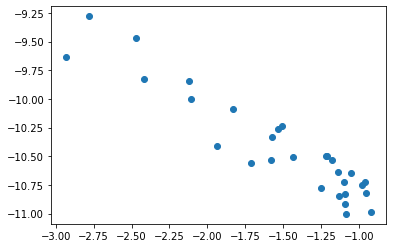

In [19]:
tmp_agent = MONES(
    make_env,
    Actor(1, 1, hidden=50),
    n_population=30,
    n_runs=30,
    logdir=None
)

state_dict = torch.load(logdir + 'checkpoint.pt')
tmp_agent.dist = state_dict[' dist']
tmp_agent.policy = state_dict[' policy']

pop, _ = tmp_agent.sample_population()
r = tmp_agent.evaluate_population(make_env(), pop)
r /= 100
mo_returns = r[r[:, 0] > -5]
plt.figure()
plt.scatter(mo_returns[:,0], mo_returns[:,1])
plt.show()

29


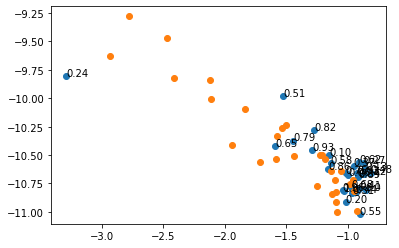

In [20]:
print(len(w_returns))
plt.figure()
plt.scatter(w_returns[:,0], w_returns[:,1])
plt.scatter(mo_returns[:,0], mo_returns[:,1])
for i, w in enumerate(np.linspace(0, 1, 30)[valid_w]):
    plt.annotate(str(w)[:4], w_returns[i])

## Using DDPG as subroutine to optimize Reward

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
from gym.wrappers import TimeLimit
import envs.dam
from wrappers.linear_scalarization import LinearScalarization
from learners.single_objective.memory import Memory
from learners.single_objective.policy import Normal
from learners.single_objective.ddpg import DDPG


class Actor(nn.Module):
    def __init__(self, nS, nA, hidden=20):
        super(Actor, self).__init__()

        self.nA = nA
        self.fc1 = nn.Linear(nS, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, nA)

        nn.init.xavier_uniform_(self.fc1.weight, gain=1)
        nn.init.xavier_uniform_(self.fc2.weight, gain=1)
        nn.init.xavier_uniform_(self.fc3.weight, gain=1)

    def forward(self, state):

        # actor
        a = torch.tanh(self.fc1(state))
        a = torch.tanh(self.fc2(a))
        a = torch.tanh(self.fc3(a))
        return a


class Critic(nn.Module):
    def __init__(self, nS, hidden=20):
        super(Critic, self).__init__()

        self.fc1 = nn.Linear(nS+1, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 1)

        nn.init.xavier_uniform_(self.fc1.weight, gain=1)
        nn.init.xavier_uniform_(self.fc2.weight, gain=1)
        nn.init.xavier_uniform_(self.fc3.weight, gain=1)

    def forward(self, state, action):
        state_action = torch.cat((state, action), dim=1)
        a = torch.tanh(self.fc1(state_action))
        a = torch.tanh(self.fc2(a))
        a = self.fc3(a)
        return a


class ReleasePercentage(gym.Wrapper):

    def reset(self):
        o = super(ReleasePercentage, self).reset()
        self._o = o
        return o
    
    def step(self, action):
        # tanh to full sized action
        action = (action + 1)*self._o[0]/2
        o, r, d, i = super(ReleasePercentage, self).step(action)
        self._o = o
        return o, r, d, i


def make_ls_env(weights):
    # weights = weights/100.
    env = ReleasePercentage(make_env())
    env = LinearScalarization(env, weights)
    return env


def make_so_subroutine(env):
    actor = Actor(1, 1, hidden=70)
    critic = Critic(1, hidden=70)
    mem = Memory(size=1000000)

    agent = DDPG(env,
                policy=Normal(np.inf, 1, noise='normal'),
                actor=actor,
                critic=critic,
                memory=mem,
                gamma=0.99,
                lr=3e-4,
                batch_size=64,
                tau=0.1,
                copy_every=1,
                n_steps_update=240,
                k=80,
                learn_start=500,
                clip_grad_norm=50,
                logdir=None)
    return agent


In [11]:
from learners.mones import run_episode
from IPython import display

all_points = []
for w_0 in np.linspace(0, 1, 30):
    print(all_points)
    agent = make_so_subroutine(make_ls_env(np.array([w_0, 1.-w_0])/100))
    agent.train(timesteps=50000)
    display.clear_output(wait=False)
    eval_runs = [run_episode(ReleasePercentage(make_env()), agent.actor) for _ in range(10)]
    eval_runs = torch.mean(torch.stack(eval_runs)/100, dim=0)
    all_points.append(eval_runs)

In [39]:
all_points

[tensor([ -0.8951, -10.2477]),
 tensor([ -0.8062, -10.6626]),
 tensor([ -1.0140, -10.1658]),
 tensor([ -0.8547, -10.4217]),
 tensor([ -0.8263, -10.0778])]

In [12]:
all_points = np.array([p.detach().numpy() for p in all_points])/100

&lt;matplotlib.collections.PathCollection at 0x7fce72e59dc0&gt;

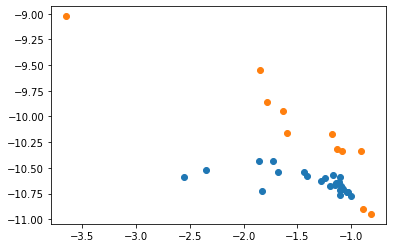

In [26]:
import pylab as plt

nd_points = all_points[all_points[:,0] > -4]
plt.figure()
plt.scatter(nd_points[:,0], nd_points[:,1])
plt.scatter(current_nd[:,0], current_nd[:,1])

In [2]:
from learners.ols import OLS
from learners.mones import run_episode
from IPython import display

def train_subroutine(env):
    agent = make_so_subroutine(env)
    agent.train(timesteps=15000)
    display.clear_output(wait=False)
    eval_run = run_episode(ReleasePercentage(make_env()), agent.actor)/100
    return eval_run

agent = OLS(
    make_ls_env,
    train_subroutine
)

In [3]:
solutions = agent.train(20, logdir=None)

RuntimeError: cannot perform reduction function max on tensor with no elements because the operation does not have an identity